<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/BIGGAN_birds_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gan tensorflow-addons -q
!rm -rf samples checkpoints
!mkdir samples checkpoints

In [ ]:
import tensorflow.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Embedding
from tensorflow.keras.layers import Wrapper, AveragePooling2D, LeakyReLU, BatchNormalization, UpSampling2D, GlobalAveragePooling2D, Reshape
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import os
import time
from IPython import display
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
from tqdm import tqdm 
import tensorflow_addons as tfa
# from tensorflow_addons.layers import SpectralNormalization //not working

from google.colab import drive, auth

print(tf.__version__)

In [47]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

Exception ignored in: <function ScopedTFFunction.__del__ at 0x7f7a9e92bc20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/c_api_util.py", line 118, in __del__
    def __del__(self):
KeyboardInterrupt


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [48]:
#@title CONSTS

IMAGE_SIZE = 64
DATASET_SIZE = 13262
BUFFER_SIZE = DATASET_SIZE
BATCH_SIZE = 32
EPOCHS = 200
LATENT_DIM = 120
CHECKPOINT_DIR = 'checkpoints'
SAMPLES_DIR = 'samples'
CHECKPOINT_INTERVAL = 10
SEED = 1
NUM_CLASSES = 100
TFRECORD_PATH = 'gs://brids-xarvel/*.tfrec'


In [49]:
weight_initializer = tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02, seed=SEED
)
weight_regularizer = None
weight_regularizer_fully = None

In [50]:
#@title Dataset

def preprocess_image(img):
    return tf.cast(img, tf.float32) / 127.5 - 1.

def get_tfrecord_dataset(
    batch_size: int,
    tfrecord_path: str,
    is_training: bool,
    *,
    image_size: int,
):
    def parse_example(proto):
        features = {
          "image": tf.io.FixedLenFeature([], tf.string), 
          'height': tf.io.FixedLenFeature([], tf.int64),
          'width': tf.io.FixedLenFeature([], tf.int64),
          'channels': tf.io.FixedLenFeature([], tf.int64),
          'label_text': tf.io.FixedLenFeature([], tf.string), 
          'label_onehot':  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
          'label_number': tf.io.FixedLenFeature([], tf.int64),
        }

        parsed = tf.io.parse_single_example(
            serialized=proto,
            features=features
        )

        image, label = parsed["image"], parsed["label_number"]
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (image_size, image_size))
    
        return image, label
    
    tfrecord_files = tf.io.gfile.glob(tfrecord_path)

    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_example)
    if is_training:
      dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
      dataset = dataset.repeat()

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(lambda image, label: (preprocess_image(image), label))
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
   
    return dataset

train_dataset = get_tfrecord_dataset(
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=False
) 

In [51]:
#@title SpectralNormalization


class SpectralNormalization(Wrapper):
    """
    Attributes:
       layer: tensorflow keras layers (with kernel attribute)
    """

    def __init__(self, layer, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        """Build `Layer`"""

        if not self.layer.built:
            self.layer.build(input_shape)

            if not hasattr(self.layer, 'kernel'):
                raise ValueError(
                    '`SpectralNormalization` must wrap a layer that'
                    ' contains a `kernel` for weights')

            self.w = self.layer.kernel
            self.w_shape = self.w.shape.as_list()
            self.u = self.add_weight(
                shape=tuple([1, self.w_shape[-1]]),
                initializer=k.initializers.TruncatedNormal(stddev=0.02),
                name='sn_u',
                trainable=False,
                dtype=tf.float32)

        super(SpectralNormalization, self).build()

    @tf.function
    def call(self, inputs):
        """Call `Layer`"""
        # Recompute weights for each forward pass
        self._compute_weights()
        output = self.layer(inputs)
        return output

    def _compute_weights(self):
        """Generate normalized weights.
        This method will update the value of self.layer.kernel with the
        normalized value, so that the layer is ready for call().
        """
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        eps = 1e-12
        _u = tf.identity(self.u)
        
        _v = tf.matmul(_u, tf.transpose(w_reshaped))
        _v = _v / tf.maximum(tf.reduce_sum(_v**2)**0.5, eps)
        _u = tf.matmul(_v, w_reshaped)
        _u = _u / tf.maximum(tf.reduce_sum(_u**2)**0.5, eps)

        self.u.assign(_u)
        sigma = tf.matmul(tf.matmul(_v, w_reshaped), tf.transpose(_u))

        self.layer.kernel = self.w / sigma

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(
            self.layer.compute_output_shape(input_shape).as_list())

In [52]:
#@title ConditionalBatchNormalization

class ConditionalBatchNormalization(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(ConditionalBatchNormalization, self).__init__(**kwargs)
    
  def build(self, input_shape):
    batch, height, width, channels = input_shape
   
    self.linear_gamma = SpectralNormalization(tf.keras.layers.Dense(channels, 
			kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully,
			use_bias = False,
			name = 'linear_gamma'))
    self.linear_beta = SpectralNormalization(tf.keras.layers.Dense(channels, 
			kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully,
			use_bias = False,
			name = 'linear_beta'))
    self.batchnorm = tf.keras.layers.BatchNormalization()

  def call(self, x, c, training=False):
    x = self.batchnorm(x, training=training)
    gamma = self.linear_gamma(c, training=training)  
    beta = self.linear_beta(c, training=training)

    return x * gamma[:, None, None] + beta[:, None, None]  

In [53]:
#@title SelfAttention

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()

    def build(self, input_shape):
        in_channels = int(input_shape[-1])

        self.conv_theta =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//8, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_phi =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//8, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_g =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//2, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_attn =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.sigma = self.add_weight('sigma', shape=[], initializer=tf.zeros_initializer())

    def call(self, x, training=None):
        batch_size, h, w, in_channels = map(int, x.shape.as_list())
        location_num = h*w
        downsampled_num = location_num//4

        theta = self.conv_theta(x, training=training)
        theta = tf.reshape(theta, [batch_size, location_num, in_channels//8])

        phi = self.conv_phi(x, training=training)
        phi = tf.nn.max_pool(phi, ksize=[2, 2], strides=2, padding='VALID')
        phi = tf.reshape(phi, [batch_size, downsampled_num, in_channels//8])

        attn = tf.matmul(theta, phi, transpose_b=True)
        attn = tf.nn.softmax(attn)

        g = self.conv_g(x, training=training)
        g = tf.nn.max_pool(g, ksize=[2, 2], strides=2, padding='VALID')
        g = tf.reshape(g, [batch_size, downsampled_num, in_channels//2])

        attn_g = tf.matmul(attn, g)
        attn_g = tf.reshape(attn_g, [batch_size, h, w, in_channels//2])
        attn_g = self.conv_attn(attn_g, training=training)

        return x + self.sigma * attn_g

In [54]:
#@title DBlock

class DBlock(Model):
  def __init__(self, channels, downsample=True, preactivation=True):
    super(DBlock, self).__init__()
    self.out_channels = channels
    self.hidden_channels = self.out_channels 
    self.activation1 = tf.keras.layers.ReLU()
    self.activation2 = tf.keras.layers.ReLU()
    self.conv33_1 = SpectralNormalization(Conv2D(filters=self.hidden_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.conv33_2 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.av_pool_1 = AveragePooling2D(padding='same')
    self.av_pool_2 = AveragePooling2D(padding='same')
    
    self.downsample = downsample
    self.preactivation = preactivation
  
  def build(self, input_shape):
    batch, height, width, channels = input_shape
    self.in_channels = channels
    self.learnable_sc = True if (self.in_channels != self.out_channels) or self.downsample else False

    if self.learnable_sc:
      self.conv_sc = tfa.layers.SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=1, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))

  def shortcut(self, x, training=False):
    if self.preactivation:
      if self.learnable_sc:
        x = self.conv_sc(x, training=training)
      if self.downsample:
        x = self.av_pool_1(x)
    else:
      if self.downsample:
        x = self.av_pool_1(x)
      if self.learnable_sc:
        x = self.conv_sc(x, training=training)
    return x

  def call(self, x, training=False):
    if self.preactivation:
      h = self.activation1(x)
    else:
      h = x    

    h = self.conv33_1(h, training=training)
    h = self.conv33_2(self.activation2(h), training=training)

    if self.downsample:
      h = self.av_pool_2(h)     
        
    return h + self.shortcut(x, training=training)           


In [55]:
#@title GBlock

class GBlock(Model):
  def __init__(self, channels):
    super(GBlock, self).__init__()
    self.out_channels = channels
    self.bn1 = ConditionalBatchNormalization()
    self.bn2 = ConditionalBatchNormalization()
    self.up_sample_1 = UpSampling2D()
    self.up_sample_2 = UpSampling2D()
    self.activation1 = tf.keras.layers.ReLU()
    self.activation2 = tf.keras.layers.ReLU()
    self.conv33_1 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.conv33_2 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.upsample = True

  def build(self, input_shape):
    batch, height, width, channels = input_shape
    self.in_channels = channels
    self.learnable_sc = self.in_channels != self.out_channels

    if self.learnable_sc:
      self.conv_sc = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=1, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
      
  def call(self, x, label, training=False):
    h = self.activation1(self.bn1(x, label, training=training))
    if self.upsample:
      h = self.up_sample_1(h)
      x = self.up_sample_2(x)

    h = self.conv33_1(h, training=training)
    h = self.activation2(self.bn2(h, label, training=training))
    h = self.conv33_2(h, training=training)

    if self.learnable_sc:       
      x = self.conv_sc(x, training=training)

    return h + x

In [56]:
#@title Generator

class Generator(Model):
  def __init__(self, channels, num_classes, embedding_size):
    super(Generator, self).__init__()
    self.channels = channels
    self.linear = SpectralNormalization(Dense(4 * 4 * 16 * channels, use_bias=False, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully))
    self.reshape = Reshape([4, 4, 16 * channels])

    self.res_block_1 = GBlock(16 * channels)
    self.res_block_2 = GBlock(16 * channels)
    self.res_block_3 = GBlock(8 * channels)
    self.attention = SelfAttention()
    self.res_block_4 = GBlock(4 * channels)

    self.embedding = Embedding(num_classes, embedding_size, embeddings_initializer=weight_initializer)

    self.bn = BatchNormalization()
    self.activation = tf.keras.layers.ReLU()
    self.conv = SpectralNormalization(Conv2D(filters=3, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.concat = tf.keras.layers.Concatenate();

  @tf.function
  def call(self, z, label, training=False):    
    z_split = tf.split(z, num_or_size_splits=5, axis=-1)
    embed = self.embedding(label)
    conds = [self.concat([z_i, embed]) for z_i in z_split[1:]]
    x = self.linear(z_split[0], training=training)
    x = self.reshape(x)
    x = self.res_block_1(x, conds[0], training=training)
    x = self.res_block_2(x, conds[1], training=training)
    x = self.res_block_3(x, conds[2], training=training)
    x = self.attention(x, training=training)
    x = self.res_block_4(x, conds[3], training=training)
    x = self.bn(x, training=training)
    x = self.activation(x)
    x = self.conv(x, training=training)
    return tf.nn.tanh(x)

(1, 64, 64, 3)


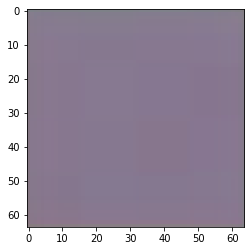

In [57]:
with strategy.scope():
  generator = Generator(64, num_classes=NUM_CLASSES, embedding_size=LATENT_DIM)
  label = tf.constant([1])
  noise = tf.random.truncated_normal([1, 120], stddev=0.5)
  generated_image = generator(noise, label, training=False)
  print(generated_image.shape)
  plt.imshow(generated_image[0] * 0.5 + 0.5)  

In [58]:
#@title Discriminator

class Discriminator(Model):
  def __init__(self, channels, num_classes):
    super(Discriminator, self).__init__()
    self.res_block_1 = DBlock(1 * channels, downsample=True, preactivation=False)
    self.res_block_2 = DBlock(2 * channels, downsample=True, preactivation=True)
    self.res_block_3 = DBlock(4 * channels, downsample=True, preactivation=True)
    self.res_block_4 = DBlock(8 * channels, downsample=True, preactivation=True)
    self.attention = SelfAttention()
    self.res_block_5 = DBlock(16 * channels, downsample=False, preactivation=True)
    self.activation = tf.keras.layers.ReLU()
    self.embedding = Embedding(num_classes, 16 * channels, embeddings_initializer=weight_initializer)

    self.linear = SpectralNormalization(
       Dense(1, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully)
    )
  
  @tf.function
  def call(self, x, label, training=False):
    x = self.res_block_1(x, training=training)
    x = self.res_block_2(x, training=training)
    x = self.res_block_3(x, training=training)
    x = self.res_block_4(x, training=training)
    x = self.attention(x, training=training)
    x = self.res_block_5(x, training=training)
    x = self.activation(x)
    x = tf.reduce_sum(x, axis=[1, 2])
    out = self.linear(x, training=training)
    embed = self.embedding(label)
    out += tf.reduce_sum(x * embed, axis=-1, keepdims=True)
    return out

In [59]:
with strategy.scope():
  discriminator = Discriminator(64, num_classes=NUM_CLASSES)
  decision = discriminator(generated_image, label)
  print(decision)

tf.Tensor([[0.00197093]], shape=(1, 1), dtype=float32)


In [60]:
per_replica_batch_size = BATCH_SIZE // strategy.num_replicas_in_sync

train_dataset = strategy.distribute_datasets_from_function(
    lambda _: get_tfrecord_dataset(
    batch_size=per_replica_batch_size,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=True
))

In [61]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_hinge_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor:
  L_D = -tf.reduce_mean(tf.minimum(0., -1.0 + logits_real)) - tf.reduce_mean(tf.minimum(0., -1.0 - logits_fake))

  return L_D    

def generator_hinge_loss(logits_fake: tf.Tensor) -> tf.Tensor:
    L_G = -tf.reduce_mean(logits_fake)
    return L_G  

In [62]:
with strategy.scope():
  generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.999,epsilon=1e-6,)
  discriminator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.0, beta_2=0.999, epsilon=1e-6)

In [63]:
fixed_noise = tf.random.truncated_normal((100, LATENT_DIM), stddev=1)

def sample_images(epoch):
  rows = 10
  cols = 10

  noise = fixed_noise

  labels = np.arange(0, 100)
  gen_imgs = generator(noise, labels)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  fig.subplots_adjust(wspace=0.01, hspace=0)

  fig.set_figheight(100)
  fig.set_figwidth(100)
  fig.set_tight_layout(True)
 
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[j * 10 + i])
  
      axs[i,j].axis('off')
  plt.savefig(SAMPLES_DIR + '/image_at_epoch_{:04d}.png'.format(epoch))
  plt.close(fig)

In [64]:
#@title train_step

with strategy.scope():
  d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
  g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

@tf.function
def train_step(iterator):
  """The step function for one training step."""

  def step_fn(inputs):
    """The computation to run on each TPU device."""
    images, labels = inputs
    noise = tf.random.normal([per_replica_batch_size, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, labels, training=True)
      gen_predictions = discriminator(generated_images, labels, training=True)
      real_predictions = discriminator(images, labels, training=True)
      disc_loss = discriminator_hinge_loss(real_predictions, gen_predictions)
      gen_loss = generator_hinge_loss(gen_predictions)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)
    discriminator_optimizer.apply_gradients(
      zip(gradients_of_discriminator, discriminator.trainable_weights)
    )
    
    d_loss_metric.update_state(disc_loss)
    g_loss_metric.update_state(gen_loss)
    return disc_loss, gen_loss

  disc_loss, gen_loss = strategy.run(step_fn, args=(next(iterator),))

  disc_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, disc_loss, axis=None)
  gen_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, gen_loss, axis=None)
  
  return disc_loss, gen_loss

In [65]:
#@title checkpoint

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
  discriminator_optimizer=discriminator_optimizer,
  generator=generator,
  discriminator=discriminator)

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")

latest_checkpoint = tf.train.latest_checkpoint(CHECKPOINT_DIR)
status = checkpoint.restore(latest_checkpoint, options=local_device_option)

if latest_checkpoint:
  first_epoch = int(latest_checkpoint.split(sep='ckpt-')[-1]) * CHECKPOINT_INTERVAL
else:
  first_epoch = 0

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")

def save_checkpoint():
  checkpoint_dir = CHECKPOINT_DIR
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint.save(file_prefix = checkpoint_prefix, options=local_device_option)

In [ ]:
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
train_iterator = iter(train_dataset)

for epoch in range(first_epoch, EPOCHS):
  start = time.time()
  print('Epoch: {}/{}'.format(epoch + 1, EPOCHS))

  pbar = tqdm(range(steps_per_epoch))
  for step in pbar:
    disc_loss, gen_loss = train_step(train_iterator)
    pbar.set_postfix({'disc_loss': round(float(disc_loss), 4), 'gen_loss': round(float(gen_loss), 4)})
    pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())
    
  if (epoch + 1) % 5 == 0:
    sample_images(epoch)
    
  if (epoch + 1) % CHECKPOINT_INTERVAL == 0:
    save_checkpoint()

  print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

Epoch: 1/200


  0%|          | 0/414 [00:00<?, ?it/s]